# 仕掛け後の上昇値（高値）の分布と下落値（安値）の分布を可視化する
仕掛け後長く保有するほど大きな上昇を捉えられる確率も損切に引っかかる確率も高くなる。この傾向のベースを測定しておくことで、特定の仕掛けを使った結果として上昇値の分布と下落値の分布がどう変わったかを評価できる。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed
from functools import reduce

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [2]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-01min.csv')

# 月次データ（1年ごとの価格変化を見るため）|
#df_spm_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-monthly.csv')

# 分析用データ作成

In [3]:
# 年の列を追加
df_sp_raw['DT'] = (df_sp_raw['Date'] + '-' + df_sp_raw['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
df_sp_raw['year'] = df_sp_raw['DT'].map(lambda x: x.year)

# 年の順序づけ
min_year = df_sp_raw['year'].min()
max_year = df_sp_raw['year'].max()
year_type = CategoricalDtype(categories=[y for y in range(min_year, max_year+1)], ordered=True)
df_sp_raw['year'] = df_sp_raw['year'].astype(year_type)

In [50]:
df = df_sp_raw.copy()

# 何足分まで見れるようにするか
MAX_NBARS = 20
df = fl.make_nbars_future(df, MAX_NBARS, cols=['High', 'Low'], datetime_col=None)

# 全期間で、N足後までの高値と安値それぞれの分布
高値と安値そのままの値ではなく、仕掛け足始値からの差分の割合の分布

In [51]:
#######################################################################
# 全データだと処理コストが高すぎるから少量のデータを使う
#######################################################################
df = df[5000000:5200000].reset_index()

In [52]:
for n in range(MAX_NBARS+1):
    print(n)
    df[f'HODiff{n}'] = df[f'High{n}'] - df['Open']
    df[f'MostUp{n}'] = df[[f'HODiff{i}' for i in range(n+1)]].max(axis=1)
    df[f'MostUpR{n}'] = df[f'MostUp{n}'] / df['Open']
    df[f'LODiff{n}'] = df[f'Low{n}'] - df['Open']
    df[f'MostDown{n}'] = df[[f'LODiff{i}' for i in range(n+1)]].min(axis=1)
    df[f'MostDownR{n}'] = df[f'MostDown{n}'] / df['Open']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [46]:
df.shape

(100000, 97)

In [47]:
a = pd.DataFrame({'a':[1,2,3],'b':[2,3,4],'c':[-1,-2,-3]})
a[['a','b','c']].max(axis=1)

0    2
1    3
2    4
dtype: int64

In [53]:
df_for_plot = pd.DataFrame(columns=['MostUpR', 'MostDownR', 'NBars'])
for n in range(MAX_NBARS+1):
    df_tmp = df[[f'MostUpR{n}', f'MostDownR{n}']]
    df_tmp = df_tmp.rename(columns={f'MostUpR{n}': 'MostUpR', f'MostDownR{n}': 'MostDownR'})
    df_tmp['NBars'] = n
    df_for_plot = pd.concat([df_for_plot, df_tmp])

df_for_plot = df_for_plot.reset_index()

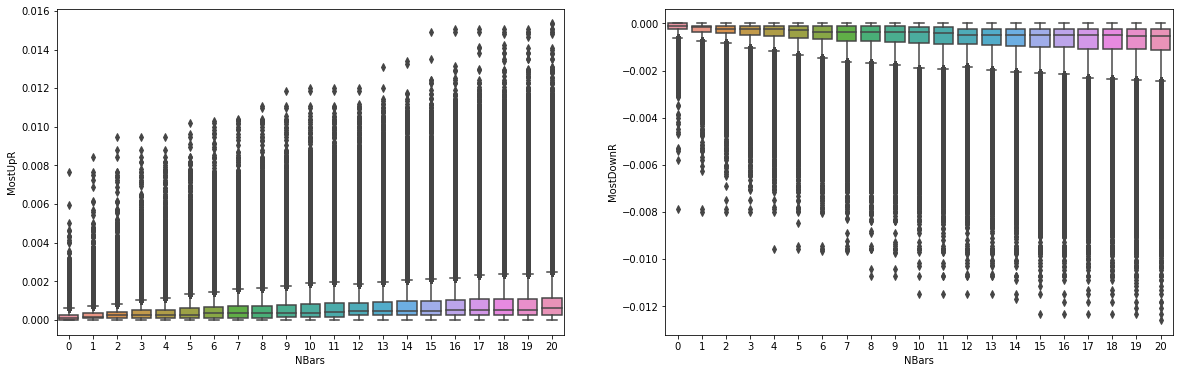

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot('NBars', 'MostUpR', data=df_for_plot, ax=ax[0])
sns.boxplot('NBars', 'MostDownR', data=df_for_plot, ax=ax[1])